In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from paretoset import paretoset
import pickle

import pickle
import sys
sys.path.append('../')
sys.path.append('../usecase_cd')
sys.path.append('../src')
import src
import utils 
from plotting_tools import read_pkl_surrogate

plt.style.use("seaborn-v0_8-paper")

font = 16
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font,
    'axes.titlesize': font
})
import warnings
warnings.filterwarnings("ignore")

/var/folders/d5/3r233ss93fv98nxsrp4wy_hc0000gn/T/ipykernel_58256/595482114.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Tutorial: Analysis of collected Pareto frontier 

This notebook serves as tutorial for analysing solutions for multiple-optimization objectives (=Pareto frontier).
1. We will look into how we can retrieve these solutions of a random 2D sample set.
2. We will investigate 
* our smallest network topology, the **(2,1)-tree**, and two random tree networks
* a random **20-node tree network**
* a random **100-node tree network**


### 1. Pareto front of a random 2D sample set 

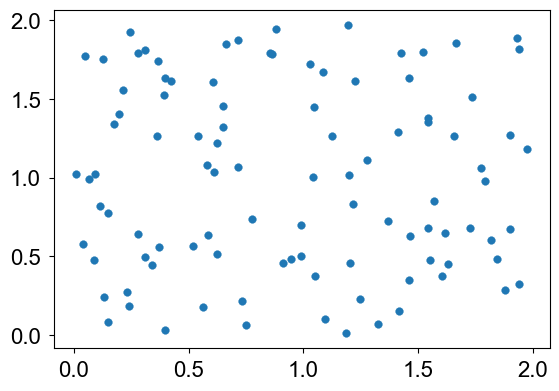

In [2]:
a = 0
b = 2
sample = (b-a) * np.random.random_sample((2,100)) + a
plt.scatter(x=sample[0], y=sample[1])
plt.show()

The Pareto frontier of the collected sample can be easiliy retrieved with `paretoset()` an algorithm implemented by [Tommy Otland, 2021](https://tommyodland.com/articles/2020/pareto-non-dominated-front-as-a-consumer-strategy/#notes-and-references) and is marked in orange below.

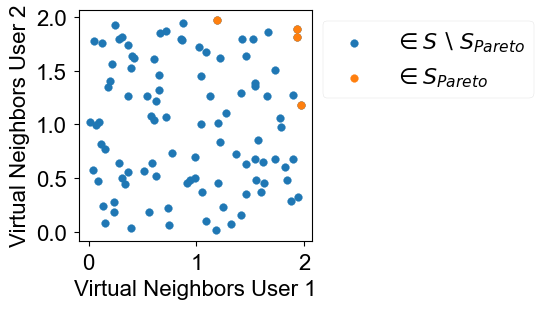

In [3]:
filter = paretoset(sample.T, sense=["max", "max"])
fig, ax = plt.subplots(figsize=[3,3])
plt.ylabel('Virtual Neighbors User 2')
plt.xlabel('Virtual Neighbors User 1')
plt.scatter(x=sample[0], y=sample[1], label=r'$\in S\setminus S_{Pareto}$')
plt.scatter(x=sample[0][filter], y=sample[1][filter], label=r'$\in S_{Pareto}$')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('simple-pareto.pdf', bbox_inches="tight")

### 2. Pareto analysis of (2,1)-tree of collected solution set

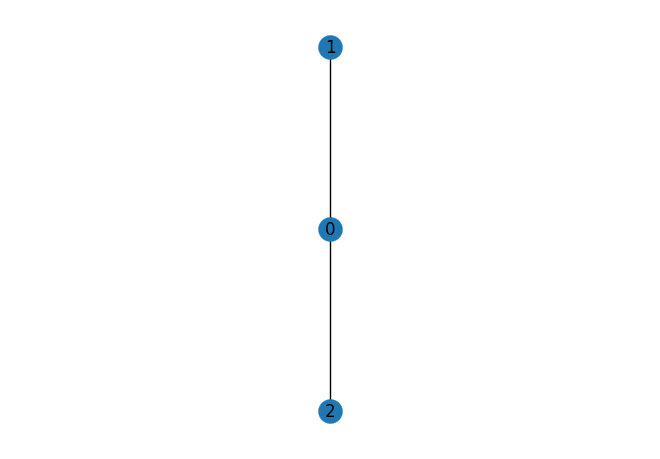

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 1)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, with_labels=True)
plt.show()

Load result data from `surdata` or run `sur.py --topo 2,1 --time 0.5` (30 min runtime). `config.py` is set with the following parameters

* 'protocol': 'ndsrs',
* 'p_gen': 0.9,
* 'p_swap': 1,
* 'return_data': 'avg',
* 'progress_bar': None,
* 'total_time': 1000,
* 'N_samples': 1000,
* 'p_cons': 0.225,
* 'qbits_per_channel': 5,
* 'cutoff': 28,
* 'M': 2,
* 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])

In [5]:
with open('../../surdata/SU_tree-2-1_20iterator_objective-meanopt_SEED42_04-23-2024_17:56:17.pkl', 'rb') as file: 
    # Load the object from the file
    sur_loaded_data = pickle.load(file)
model = sur_loaded_data

In [6]:
model.vals

{'protocol': 'ndsrs',
 'p_gen': 0.9,
 'p_swap': 1,
 'return_data': 'avg',
 'progress_bar': None,
 'total_time': 1000,
 'N_samples': 1000,
 'p_cons': 0.225,
 'qbits_per_channel': 5,
 'cutoff': 28,
 'M': 2,
 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])}

Excursion: How to calculate which cutoff time to set (given total runtime $T$, $M$, $F_\mathrm{new}$ and $F_\mathrm{app}$ according to [Inesta et al.,2023](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.108.052615))

In [7]:
T = 1000
M = 4
Fnew = 0.888
Fapp = 0.6
-T*np.log( 3/(4*Fnew-1) * ((4*Fapp-1)/3)**(1/M) )

28.800089826157972

In [8]:
virtual_neighbours = pd.DataFrame(model.y) 
virtual_neighbours.columns = [f'User {i}' for i in range(3)]
virtual_neighbours = virtual_neighbours[['User 0', 'User 1', 'User 2']]
virtual_neighbours

,User 0,User 1,User 2
0,0.243243,1.123123,1.120120
1,0.978979,1.464464,1.470470
2,0.162162,1.085085,1.077077
3,0.380380,1.188188,1.190190
4,1.993994,1.302302,1.302302
...,...,...,...
185,1.879880,1.638639,1.636637
186,1.856857,1.612613,1.613614
187,1.850851,1.611612,1.610611
188,1.859860,1.630631,1.638639


Again calculate the Pareto frontier of the collected set $S_\mathrm{Parto}$

In [9]:
vn = virtual_neighbours.to_numpy()
filter = paretoset(vn, sense=["max"]*3)
print(len(filter))

190


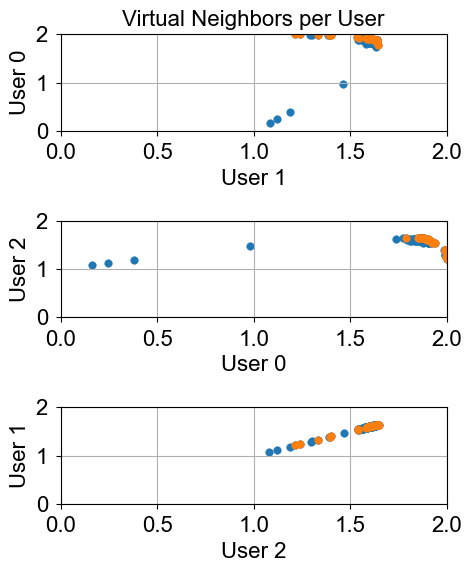

In [10]:
fig, axs = plt.subplots(3,sharey=False, sharex=False, figsize=[5,6])
labels = [1,0,2,1]
for i,ax in enumerate(axs):
    ax.scatter(x=vn[:,labels[i]], y=vn[:,labels[i+1]])
    ax.scatter(x=vn[:,labels[i]][filter], y=vn[:,labels[i+1]][filter])
    ax.set_xlabel(f'User {labels[i]}')
    ax.set_ylabel(f'User {labels[i+1]}')
    ax.set_ylim([0,2])
    ax.set_xlim([0,2])
    ax.grid()
axs[0].set_title('Virtual Neighbors per User')
plt.tight_layout()
plt.show()

And as 3D version

In [11]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
virtual_neighbours['filter'] = filter
fig = px.scatter_3d(virtual_neighbours, x=virtual_neighbours.columns[0], y=virtual_neighbours.columns[1], z=virtual_neighbours.columns[2],
              color='filter')
plt.tight_layout()
fig.show()

<Figure size 640x440 with 0 Axes>

Now, we will plot the distribution of the probability values in $S_\mathrm{Parto}$

In [12]:
model.X_df[filter].drop(['Iteration'], axis=1)

,q_swap0,q_swap1
5,0.116943,0.476471
6,0.079909,0.514405
7,0.076213,0.452359
8,0.099832,0.466092
16,0.124359,0.443842
17,0.212055,0.268741
19,0.239073,0.00432
22,0.179792,0.05291
25,0.189472,0.020569
26,0.183465,0.170676


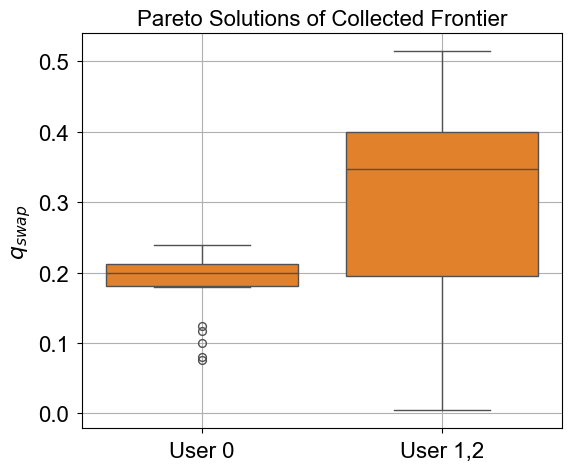

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
g = sns.boxplot(model.X_df[filter].drop(['Iteration'], axis=1), palette=['tab:orange'])
g.set_xticklabels(['User 0', 'User 1,2'])
plt.ylabel(r'$q_{swap}$')
plt.title('Pareto Solutions of Collected Frontier')
plt.grid()
plt.tight_layout()
plt.savefig('cd-21tree-pareto.pdf')
plt.show()

We can see that the parameter distribution in the dominating set pretty much coveres the optimal aggregated behaviour of the simulation (in terms of achieved virtual neighbors for each user):

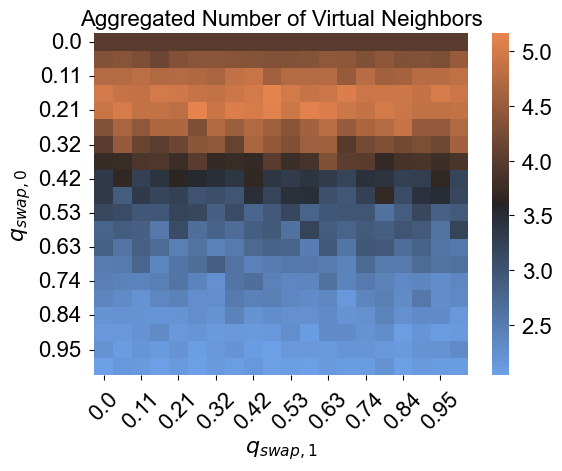

In [14]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
df_plot = pd.read_pickle('../usecase_cd/21tree-heatmap.pkl')
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_plot, cmap=cmap) #cbar_kws={'label': 'Aggregated Virtual Neighbors'}
plt.xlabel(r'$q_{swap,1}$')
plt.ylabel(r'$q_{swap,0}$')
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
plt.title('Aggregated Number of Virtual Neighbors')
plt.tight_layout()
plt.savefig('cd-21tree-heatmap.pdf')

Now, we will go to a larger layout, a random **20-node tree network** involving 7 users:

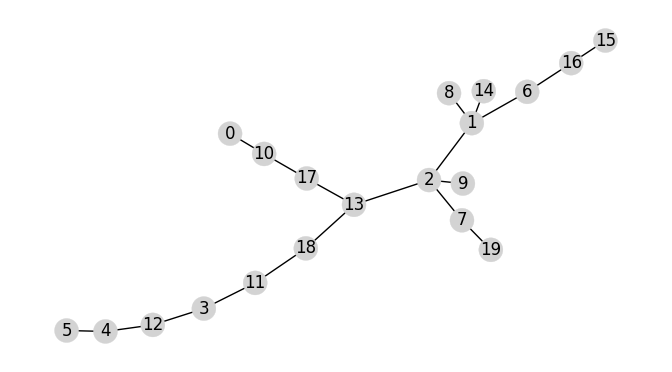

In [15]:
n=20
graph = nx.random_tree(n, seed=7)
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph-plain.pdf')

Load the result data of the surrogate optimization (or execute it with according parameters) and again retrieve the dominating set from the collected training data:

In [16]:
with open('../../surdata/cd/SU_randtree-20_0.05iterator_objective-meanopt_SEED42_05-01-2024_11:27:56.pkl', 'rb') as file: 
    # Load the object from the file
    sur_loaded_data = pickle.load(file)
model = sur_loaded_data
model.vals

{'protocol': 'ndsrs',
 'p_gen': 0.9,
 'p_swap': 1,
 'return_data': 'avg',
 'progress_bar': None,
 'total_time': 1000,
 'N_samples': 20,
 'p_cons': 0.225,
 'qbits_per_channel': 5,
 'cutoff': 28,
 'M': 10,
 'A': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 

In [17]:
folder = '../../surdata/cd'
df, vals = read_pkl_surrogate(folder)
df = df.drop('index',axis=1)
vals['user']

(array([ 0,  5,  8,  9, 14, 15, 19]),)

In [18]:
df_q_vn = df.drop(df.columns[df.columns.str.contains('std|Std|Method|Utility|Trial|Iteration')], axis=1)
vn = df_q_vn.drop(df.columns[df.columns.str.contains('q_swap')], axis=1)
vn.columns = vals['user'][0]
df_q = df_q_vn[df.columns[df.columns.str.contains('q_swap')]]

We get the following values for the overall virtual neighbors

In [19]:
vn

,0,5,8,9,14,15,19
0,1.578947,2.000000,2.000000,1.263158,2.157895,1.526316,1.526316
1,1.000000,1.578947,1.684211,1.894737,1.526316,1.789474,1.105263
2,1.368421,1.894737,1.842105,1.789474,1.842105,1.315789,2.157895
3,1.315789,1.789474,1.000000,1.842105,1.157895,1.105263,1.631579
4,2.315789,1.157895,1.368421,1.578947,1.526316,1.000000,1.684211
...,...,...,...,...,...,...,...
285,2.842105,2.526316,2.105263,2.105263,2.263158,1.736842,2.210526
286,2.736842,2.210526,2.736842,2.421053,1.947368,1.421053,2.789474
287,2.421053,2.157895,2.473684,2.578947,1.894737,1.631579,2.421053
288,2.368421,2.473684,2.052632,2.421053,2.105263,1.684211,2.263158


... from which we retrieve the dominating set

In [20]:
def get_pareto_frontier(vn, q_set):
    vn_to_analyse = vn
    filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
    return q_set[filter], sum(filter)

(this can take a few seconds)

In [21]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)
size

102

Let's look at the overall distribution of swap probability values in the dominating set

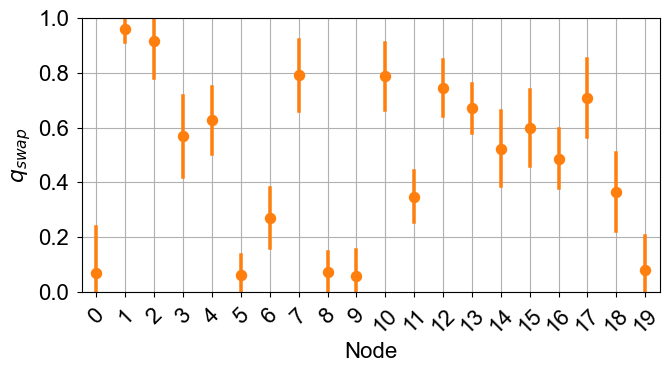

In [22]:
import re
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_q_filtered, palette={'tab:orange'}, errorbar='sd', ax=ax)#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto.pdf')

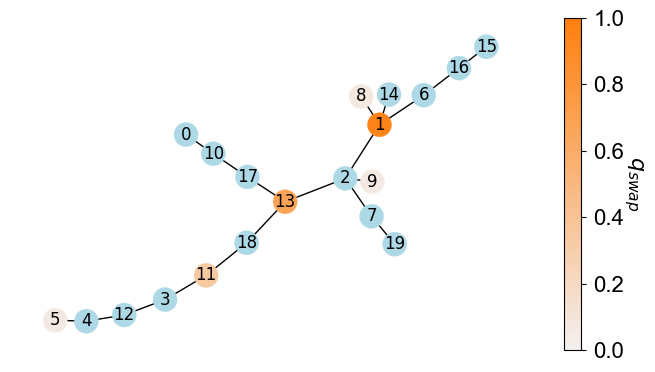

In [23]:
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
for idx in labels:
    colors[int(idx)] = cmap(df_q_filtered['q_swap'+idx].mean()) if df_q_filtered['q_swap'+idx].std() <= 0.1 else 'lightblue'
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph.pdf')

The last layout we will investigate is a **100-node network** involing 39 users

In [24]:
folder = '../../surdata/cd_10h'
df, vals = read_pkl_surrogate(folder)
df = df.drop('index',axis=1)
vals['user']

(array([ 0,  1,  2,  3, 14, 16, 20, 22, 25, 29, 32, 33, 34, 35, 42, 44, 45,
        48, 49, 51, 52, 56, 60, 61, 66, 75, 76, 78, 82, 84, 85, 86, 88, 90,
        92, 94, 95, 97, 98]),)

In [25]:
df_q_vn = df.drop(df.columns[df.columns.str.contains('std|Std|Method|Utility|Trial|Iteration')], axis=1)
vn = df_q_vn.drop(df.columns[df.columns.str.contains('q_swap')], axis=1)
vn.columns = vals['user'][0]
df_q = df_q_vn[df.columns[df.columns.str.contains('q_swap')]]

In [26]:
vn

,0,1,2,3,14,16,20,22,25,29,...,84,85,86,88,90,92,94,95,97,98
0,1.421053,2.210526,1.157895,1.263158,1.894737,1.789474,1.421053,1.315789,2.052632,1.421053,...,1.157895,1.842105,1.210526,1.894737,2.000000,1.210526,1.526316,1.157895,1.894737,1.105263
1,1.631579,1.263158,1.000000,2.052632,1.368421,1.631579,1.526316,1.210526,1.578947,1.263158,...,1.789474,1.052632,1.368421,2.052632,1.789474,2.052632,1.684211,1.736842,1.526316,1.578947
2,1.421053,1.842105,1.894737,1.526316,1.105263,1.578947,1.526316,2.000000,1.157895,1.210526,...,1.684211,1.210526,1.631579,1.578947,1.947368,1.789474,1.684211,1.526316,1.473684,0.842105
3,1.263158,1.315789,2.052632,1.947368,1.526316,1.473684,1.000000,1.631579,1.789474,1.473684,...,2.000000,1.473684,1.210526,1.105263,1.736842,1.578947,2.052632,1.578947,1.315789,1.526316
4,1.368421,1.157895,1.684211,1.315789,1.105263,1.052632,1.263158,1.421053,1.473684,1.263158,...,1.684211,1.368421,1.315789,1.473684,1.052632,1.789474,1.105263,1.947368,2.000000,1.263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9515,2.157895,2.578947,1.894737,2.210526,2.421053,2.210526,2.368421,2.526316,2.315789,1.736842,...,1.578947,1.894737,2.105263,2.000000,2.578947,2.368421,2.263158,2.157895,2.157895,1.526316
9516,1.947368,2.421053,2.210526,2.421053,2.368421,2.210526,2.157895,2.578947,2.368421,2.105263,...,1.842105,2.263158,2.105263,2.052632,2.473684,2.105263,2.315789,2.157895,2.157895,1.368421
9517,1.894737,1.947368,2.000000,2.421053,1.684211,2.000000,2.000000,2.526316,2.368421,1.684211,...,1.947368,2.000000,2.157895,2.000000,2.263158,2.105263,2.578947,2.263158,1.789474,2.263158
9518,1.947368,2.631579,2.526316,2.315789,2.210526,2.315789,1.947368,2.526316,1.736842,1.578947,...,1.736842,1.578947,2.473684,2.315789,2.000000,2.157895,2.210526,2.000000,1.631579,1.631579


Let's again retrieve the dominating set (can take a few seconds)

In [27]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)

Most distributions are widely spread with a sd above 0.2.

In [28]:
df_q_filtered.std(axis=0)[df_q_filtered.std(axis=0) < 0.2]

q_swap7     0.167406
q_swap8     0.191738
q_swap31    0.190268
q_swap50    0.195241
q_swap74    0.160882
dtype: object

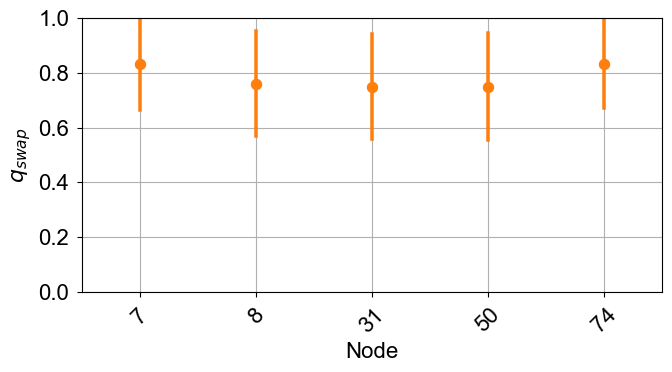

In [29]:
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_q_filtered[df_q_filtered.columns[df_q_filtered.std(axis=0) < 0.2]], palette={'tab:orange'}, errorbar='sd', ax=ax)#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree100-pareto.pdf')

At last, let's look at the best found solution of the largest dataset (since we cannot gain too much insight from the Pareto set anymore)

In [34]:
qvals = df_q.iloc[vn.sum(axis=1).argmax()]
print(qvals)

q_swap0     0.106753
q_swap1      0.07387
q_swap2     0.183184
q_swap3     0.038934
q_swap4     0.468381
              ...   
q_swap95    0.083468
q_swap96    0.629204
q_swap97    0.036317
q_swap98     0.36961
q_swap99    0.392892
Name: 9516, Length: 100, dtype: object


In [35]:
n=100
graph = nx.random_tree(n, seed=7)

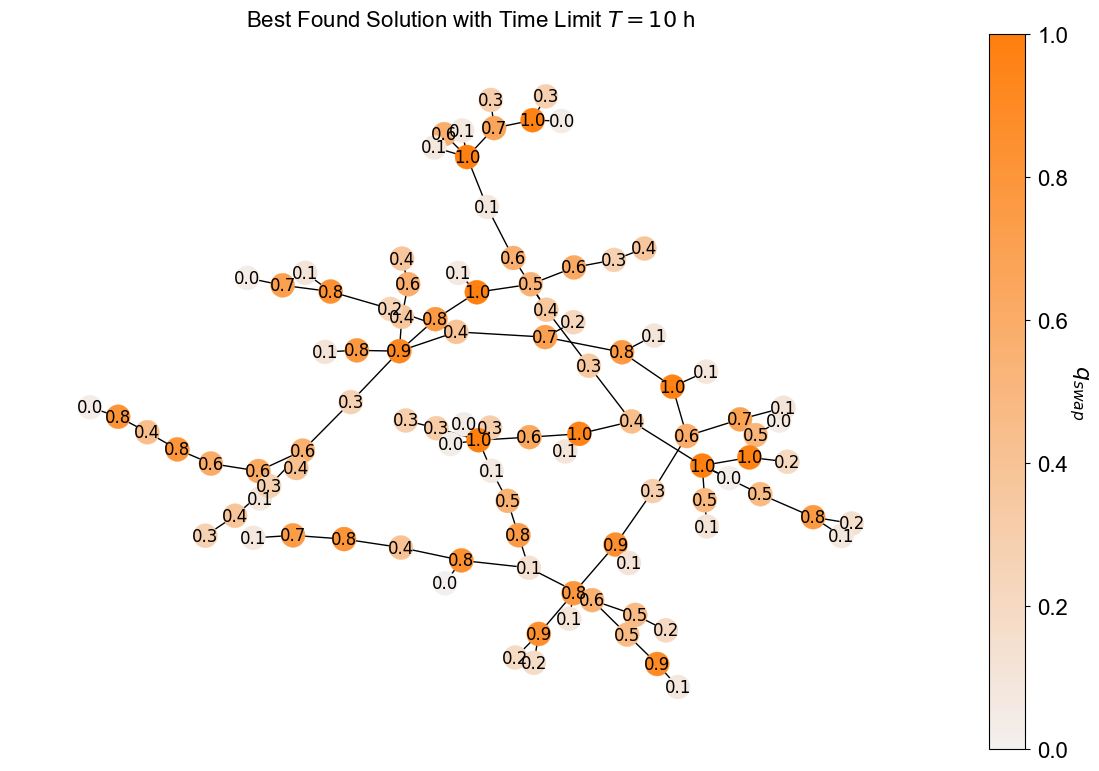

In [36]:

cmap =  sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = [cmap(qswap_mean) for qswap_mean in qvals]
labels = {node: round(val,1) for node, val in enumerate(qvals)}
nx.draw(graph, pos, with_labels=False, node_color=colors, node_size=300)
nx.draw_networkx_labels(graph, pos, labels=labels)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.title(r'Best Found Solution with Time Limit $T = 10$ h')
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree-best.pdf')